## COGS 181 Project: Convolutional Neural Network on CIFAR-10 database

Calixto Calangi


In [1]:
# Necessary code
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

## Types of implementations

In this project, I will testing across several different implementations, recording the best hyper-parameters for each.

### The first test, I will test across different architectures (custom CNN based on our COGS 181 course) v. architecture based on PyTorch

After that, I will tinker with my CNN and do a series of changes to look at the results versus the baseline recorded in my original CNN (the one used versus PyTorch architecture.

### Then, I will be looking at (for my own CNN):

#### 1.) Varying layers
#### 2.) Different optimization methods (Adam v. stochastic gradient descent)
#### 3.) Different pooling functions (average pooling, max pooling, stochastic pooling)
#### 4.) Different activation functions (ReLu, Sigmoid)


### Preparing Dataset: transforming

In [103]:
#transform code, architecture same to HW4
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

#labels
classes = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


### Choosing what device

In [6]:
device_CustomCNN = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device_CustomCNN)  

cuda:0


In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


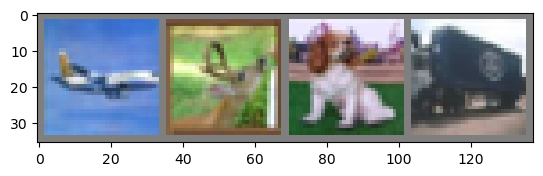

airplane  deer   dog truck


In [104]:
### Images for point of reference
def imshow(img):
    img = img / 2 + 0.5     # Unnormalize.
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images.
dataiter = iter(trainloader)
images, labels = next(dataiter)
# Show images.
imshow(torchvision.utils.make_grid(images))
# Print labels.
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

# Section 1: Custom CNN architecture v. Baseline CNN architecture (PyTorch)

## Test 1: comparing my CNN to the basic CNN from PyTorch architecture

In this section, I will be looking at the two architectures.

In [7]:
### Architecture 1: my own CNN
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Sequential(
          nn.Conv2d(3, 20, 3, stride=1, padding=1),
          nn.ReLU(),
          nn.AvgPool2d(2)
        )
        self.conv2 = nn.Sequential(
          nn.Conv2d(20,20,3, stride=1, padding=1),
          nn.ReLU(),
          nn.AvgPool2d(2)
        )
        self.fc1= nn.Linear(1280,1280)
        self.fc2= nn.Linear(1280,100)
        self.relu= nn.ReLU()
        self.fc3 = nn.Linear(100,10)
      
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = torch.flatten(x,1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.fc3(x)
    
        return x

net = Net()     # Create the network instance.
net.to(device_CustomCNN)  # Move the network parameters to the specified device.

Net(
  (conv1): Sequential(
    (0): Conv2d(3, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (conv2): Sequential(
    (0): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (fc1): Linear(in_features=1280, out_features=1280, bias=True)
  (fc2): Linear(in_features=1280, out_features=100, bias=True)
  (relu): ReLU()
  (fc3): Linear(in_features=100, out_features=10, bias=True)
)

In [8]:
### Architecture 2: PyTorch  architecture
### To get some baseline for results, I used the PyTorch Tutorial
### as a basic comparison to see if I get similar results

class Pytorch_Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Pytorch_Net = Pytorch_Net() 
Pytorch_Net = Pytorch_Net.to(device)  

#### Optimizer and Loss function:
To keep it consistent with AlexNet architecture, which utilizes cross-entropy loss and stochastic gradient descent, I will also keep it for both. Learning rate will maintain the same value (0.001)

In [9]:
##### loss, optimizer
###for cnn
loss_func = nn.CrossEntropyLoss()  
opt = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) 

###for basic architecture
opt_ba = optim.SGD(Pytorch_Net.parameters(), lr=0.001, momentum=0.9)

#### Training: My CNN

In [86]:
#### My own CNN training
avg_losses_CustomCNN = []   # Avg. losses.
epochs = 10       # Total epochs.
print_freq = 100  # Print frequency.

for epoch in range(epochs):  # Loop over the dataset multiple times.
    running_loss = 0.0       # Initialize running loss.
    for i, data in enumerate(trainloader, 0):
        # Get the inputs.
        inputs, labels = data
        
        # Move the inputs to the specified device.
        inputs, labels = inputs.to(device_CustomCNN), labels.to(device_CustomCNN)
        
        # Zero the parameter gradients.
        opt.zero_grad()

        # Forward step.
        outputs = net(inputs)
        loss = loss_func(outputs, labels)
        
        # Backward step.
        loss.backward()
        
        # Optimization step (update the parameters).
        opt.step()

        # Print statistics.
        running_loss += loss.item()
        if i % print_freq == print_freq - 1: # Print every several mini-batches.
            avg_loss = running_loss / print_freq
            print('[epoch: {}, i: {:5d}] avg mini-batch loss: {:.3f}'.format(
                epoch, i, avg_loss))
            avg_losses_CustomCNN.append(avg_loss)
            running_loss = 0.0

print('Finished Training.')

[epoch: 0, i:    99] avg mini-batch loss: 2.305
[epoch: 0, i:   199] avg mini-batch loss: 2.303
[epoch: 0, i:   299] avg mini-batch loss: 2.301
[epoch: 0, i:   399] avg mini-batch loss: 2.293
[epoch: 0, i:   499] avg mini-batch loss: 2.286
[epoch: 0, i:   599] avg mini-batch loss: 2.272
[epoch: 0, i:   699] avg mini-batch loss: 2.216
[epoch: 0, i:   799] avg mini-batch loss: 2.167
[epoch: 0, i:   899] avg mini-batch loss: 2.123
[epoch: 0, i:   999] avg mini-batch loss: 2.118
[epoch: 0, i:  1099] avg mini-batch loss: 2.091
[epoch: 0, i:  1199] avg mini-batch loss: 2.106
[epoch: 0, i:  1299] avg mini-batch loss: 2.059
[epoch: 0, i:  1399] avg mini-batch loss: 2.021
[epoch: 0, i:  1499] avg mini-batch loss: 2.040
[epoch: 0, i:  1599] avg mini-batch loss: 1.994
[epoch: 0, i:  1699] avg mini-batch loss: 1.993
[epoch: 0, i:  1799] avg mini-batch loss: 1.954
[epoch: 0, i:  1899] avg mini-batch loss: 1.927
[epoch: 0, i:  1999] avg mini-batch loss: 1.877
[epoch: 0, i:  2099] avg mini-batch loss

#### Training: Basic CNN architecture

In [106]:
#### Basic architecture (PyTorch) training
avg_losses = []   # Avg. losses.
epochs = 10       # Total epochs.
print_freq = 100  # Print frequency.

for epoch in range(epochs):  # Loop over the dataset multiple times.
    running_loss = 0.0       # Initialize running loss.
    for i, data in enumerate(trainloader, 0):
        # Get the inputs.
        inputs, labels = data
        
        # Move the inputs to the specified device.
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients.
        opt_ba.zero_grad()

        # Forward step.
        outputs = Pytorch_Net(inputs)
        loss = loss_func(outputs, labels)
        
        # Backward step.
        loss.backward()
        
        # Optimization step (update the parameters).
        opt_ba.step()

        # Print statistics.
        running_loss += loss.item()
        if i % print_freq == print_freq - 1: # Print every several mini-batches.
            avg_loss = running_loss / print_freq
            print('[epoch: {}, i: {:5d}] avg mini-batch loss: {:.3f}'.format(
                epoch, i, avg_loss))
            avg_losses.append(avg_loss)
            running_loss = 0.0

print('Finished Training.')

[epoch: 0, i:    99] avg mini-batch loss: 1.560
[epoch: 0, i:   199] avg mini-batch loss: 1.610
[epoch: 0, i:   299] avg mini-batch loss: 1.651
[epoch: 0, i:   399] avg mini-batch loss: 1.567
[epoch: 0, i:   499] avg mini-batch loss: 1.577
[epoch: 0, i:   599] avg mini-batch loss: 1.516
[epoch: 0, i:   699] avg mini-batch loss: 1.471
[epoch: 0, i:   799] avg mini-batch loss: 1.479
[epoch: 0, i:   899] avg mini-batch loss: 1.538
[epoch: 0, i:   999] avg mini-batch loss: 1.562
[epoch: 0, i:  1099] avg mini-batch loss: 1.471
[epoch: 0, i:  1199] avg mini-batch loss: 1.486
[epoch: 0, i:  1299] avg mini-batch loss: 1.549
[epoch: 0, i:  1399] avg mini-batch loss: 1.512
[epoch: 0, i:  1499] avg mini-batch loss: 1.518
[epoch: 0, i:  1599] avg mini-batch loss: 1.523
[epoch: 0, i:  1699] avg mini-batch loss: 1.536
[epoch: 0, i:  1799] avg mini-batch loss: 1.497
[epoch: 0, i:  1899] avg mini-batch loss: 1.467
[epoch: 0, i:  1999] avg mini-batch loss: 1.520
[epoch: 0, i:  2099] avg mini-batch loss

#### Plot training curve

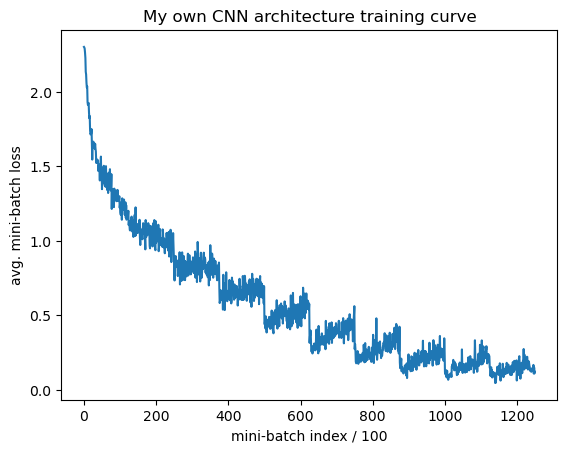

In [11]:
#### My own CNN architecture
plt.plot(avg_losses_CustomCNN)
plt.xlabel('mini-batch index / {}'.format(print_freq))
plt.ylabel('avg. mini-batch loss')
plt.title("My own CNN architecture training curve")
plt.show()

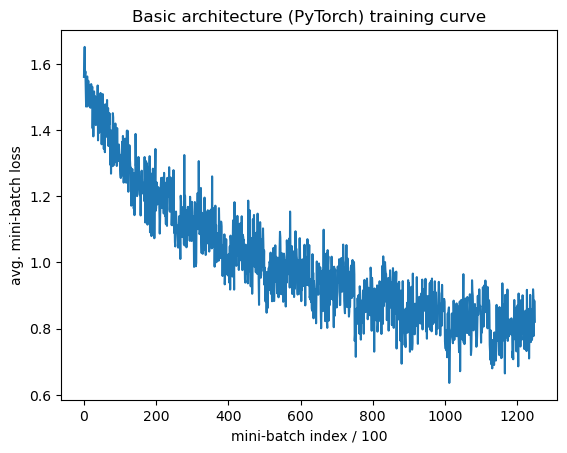

In [107]:
#### Basic architecture training curve
plt.plot(avg_losses)
plt.xlabel('mini-batch index / {}'.format(print_freq))
plt.ylabel('avg. mini-batch loss')
plt.title("Basic architecture (PyTorch) training curve")
plt.show()

#### Test accuracy

In [278]:
#### 1.) own CNN architecture
# Get test accuracy.
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device_CustomCNN), labels.to(device_CustomCNN)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 67 %


In [111]:
#### 2.) basic architecture (PyTorch)
# Get test accuracy.
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = Pytorch_Net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 63 %


## Conclusion for Architecture

There was more variability in the training based on the PyTorch/basic CNN architecture versus this project's CNN.

However, the important parts are the final test accuracy scores; 67% in this project's CNN v. 63% in the basic architecture.

This helps to us moving forward, as this project's CNN is generally the same/slightly better than a baseline CNN architecture. Knowing this, this moves to the next section: investigating the various hyper-parameters and different implementations to further improve it to better understand what facets of a CNN improve it in terms of image classification.

The primary lens is via the next 4 sections, investigating their effects and seeing how much they contribute/affect the performance in terms of their test accuracy scores on test images.

# Section 2: Hyper-parameter testing on the project CNN architecture

## Test 2: Varying layers in my CNN

As we have already tested with just 2 layers in the first test, we will vary it with additional layers.

We will be looking at the effects of an additonal 3rd and 4th layer respectively.

In [10]:
#### 3, 4 layers
class Layers3_Net(nn.Module):
    def __init__(self):
        super(Layers3_Net, self).__init__()
        self.conv1 = nn.Sequential(
          nn.Conv2d(3, 20, 3, stride=1, padding=1),
          nn.ReLU(),
          nn.AvgPool2d(2)
        )
        self.conv2 = nn.Sequential(
          nn.Conv2d(20,20,3, stride=1, padding=1),
          nn.ReLU(),
          nn.AvgPool2d(2)
        )
        self.conv3 = nn.Sequential(
          nn.Conv2d(20,40,3, stride=1, padding=1),
          nn.ReLU(),
          nn.AvgPool2d(2)
        )
        self.fc1= nn.Linear(640,1280)
        self.fc2= nn.Linear(1280,100)
        self.relu= nn.ReLU()
        self.fc3 = nn.Linear(100,10)
      
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = torch.flatten(x,1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.fc3(x)
    
        return x

class Layers4_Net(nn.Module):
    def __init__(self):
        super(Layers4_Net, self).__init__()
        self.conv1 = nn.Sequential(
          nn.Conv2d(3, 20, 3, stride=1, padding=1),
          nn.ReLU(),
          nn.AvgPool2d(2)
        )
        self.conv2 = nn.Sequential(
          nn.Conv2d(20,20,3, stride=1, padding=1),
          nn.ReLU(),
          nn.AvgPool2d(2)
        )
        self.conv3 = nn.Sequential(
          nn.Conv2d(20,40,3, stride=1, padding=1),
          nn.ReLU(),
          nn.AvgPool2d(2)
        )
        self.conv4 = nn.Sequential(
          nn.Conv2d(40,40,3, stride=1, padding=1),
          nn.ReLU(),
          nn.AvgPool2d(2)
        )
        self.fc1= nn.Linear(160,1280)
        self.fc2= nn.Linear(1280,100)
        self.relu= nn.ReLU()
        self.fc3 = nn.Linear(100,10)
      
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = torch.flatten(x,1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.fc3(x)
    
        return x

#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
Layer_3 = Layers3_Net()
Layer_3.to(device)

Layer_4 = Layers4_Net()
Layer_4.to(device)

Layers4_Net(
  (conv1): Sequential(
    (0): Conv2d(3, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (conv2): Sequential(
    (0): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (conv3): Sequential(
    (0): Conv2d(20, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (conv4): Sequential(
    (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (fc1): Linear(in_features=160, out_features=1280, bias=True)
  (fc2): Linear(in_features=1280, out_features=100, bias=True)
  (relu): ReLU()
  (fc3): Linear(in_features=100, out_features=10, bias=True)
)

#### Loss and optimizer function

Since we want to look solely at the performance of additional layers, I am keeping all other variables constant, including the optimizer and loss functions.

In [11]:
##### loss, optimizer
###for layer 3
opt_layer3 = optim.SGD(Layer_3.parameters(), lr=0.001, momentum=0.9) 

###for basic architecture
opt_layer4 = optim.SGD(Layer_4.parameters(), lr=0.001, momentum=0.9)

#### Training

In [123]:
#### Layer 3 CNN training
avg_losses_CustomCNN = []   # Avg. losses.
epochs = 10       # Total epochs.
print_freq = 100  # Print frequency.

for epoch in range(epochs):  # Loop over the dataset multiple times.
    running_loss = 0.0       # Initialize running loss.
    for i, data in enumerate(trainloader, 0):
        # Get the inputs.
        inputs, labels = data
        
        # Move the inputs to the specified device.
        inputs, labels = inputs.to(device_CustomCNN), labels.to(device_CustomCNN)
        
        # Zero the parameter gradients.
        opt_layer3.zero_grad()

        # Forward step.
        outputs = Layer_3(inputs)
        loss = loss_func(outputs, labels)
        
        # Backward step.
        loss.backward()
        
        # Optimization step (update the parameters).
        opt_layer3.step()

        # Print statistics.
        running_loss += loss.item()
        if i % print_freq == print_freq - 1: # Print every several mini-batches.
            avg_loss = running_loss / print_freq
            print('[epoch: {}, i: {:5d}] avg mini-batch loss: {:.3f}'.format(
                epoch, i, avg_loss))
            avg_losses_CustomCNN.append(avg_loss)
            running_loss = 0.0

print('Finished Training.')

[epoch: 0, i:    99] avg mini-batch loss: 2.305
[epoch: 0, i:   199] avg mini-batch loss: 2.304
[epoch: 0, i:   299] avg mini-batch loss: 2.305
[epoch: 0, i:   399] avg mini-batch loss: 2.303
[epoch: 0, i:   499] avg mini-batch loss: 2.303
[epoch: 0, i:   599] avg mini-batch loss: 2.301
[epoch: 0, i:   699] avg mini-batch loss: 2.298
[epoch: 0, i:   799] avg mini-batch loss: 2.301
[epoch: 0, i:   899] avg mini-batch loss: 2.294
[epoch: 0, i:   999] avg mini-batch loss: 2.303
[epoch: 0, i:  1099] avg mini-batch loss: 2.299
[epoch: 0, i:  1199] avg mini-batch loss: 2.298
[epoch: 0, i:  1299] avg mini-batch loss: 2.297
[epoch: 0, i:  1399] avg mini-batch loss: 2.287
[epoch: 0, i:  1499] avg mini-batch loss: 2.283
[epoch: 0, i:  1599] avg mini-batch loss: 2.276
[epoch: 0, i:  1699] avg mini-batch loss: 2.259
[epoch: 0, i:  1799] avg mini-batch loss: 2.234
[epoch: 0, i:  1899] avg mini-batch loss: 2.155
[epoch: 0, i:  1999] avg mini-batch loss: 2.079
[epoch: 0, i:  2099] avg mini-batch loss

In [132]:
#### Layer 4 CNN training
avg_losses_fourlayers = []   # Avg. losses.
epochs = 10       # Total epochs.
print_freq = 100  # Print frequency.

for epoch in range(epochs):  # Loop over the dataset multiple times.
    running_loss = 0.0       # Initialize running loss.
    for i, data in enumerate(trainloader, 0):
        # Get the inputs.
        inputs, labels = data
        
        # Move the inputs to the specified device.
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients.
        opt_layer4.zero_grad()

        # Forward step.
        outputs = Layer_4(inputs)
        loss = loss_func(outputs, labels)
        
        # Backward step.
        loss.backward()
        
        # Optimization step (update the parameters).
        opt_layer4.step()

        # Print statistics.
        running_loss += loss.item()
        if i % print_freq == print_freq - 1: # Print every several mini-batches.
            avg_loss = running_loss / print_freq
            print('[epoch: {}, i: {:5d}] avg mini-batch loss: {:.3f}'.format(
                epoch, i, avg_loss))
            avg_losses_fourlayers.append(avg_loss)
            running_loss = 0.0

print('Finished Training.')

[epoch: 0, i:    99] avg mini-batch loss: 2.304
[epoch: 0, i:   199] avg mini-batch loss: 2.303
[epoch: 0, i:   299] avg mini-batch loss: 2.305
[epoch: 0, i:   399] avg mini-batch loss: 2.303
[epoch: 0, i:   499] avg mini-batch loss: 2.300
[epoch: 0, i:   599] avg mini-batch loss: 2.305
[epoch: 0, i:   699] avg mini-batch loss: 2.301
[epoch: 0, i:   799] avg mini-batch loss: 2.302
[epoch: 0, i:   899] avg mini-batch loss: 2.301
[epoch: 0, i:   999] avg mini-batch loss: 2.302
[epoch: 0, i:  1099] avg mini-batch loss: 2.308
[epoch: 0, i:  1199] avg mini-batch loss: 2.304
[epoch: 0, i:  1299] avg mini-batch loss: 2.304
[epoch: 0, i:  1399] avg mini-batch loss: 2.304
[epoch: 0, i:  1499] avg mini-batch loss: 2.302
[epoch: 0, i:  1599] avg mini-batch loss: 2.306
[epoch: 0, i:  1699] avg mini-batch loss: 2.307
[epoch: 0, i:  1799] avg mini-batch loss: 2.303
[epoch: 0, i:  1899] avg mini-batch loss: 2.303
[epoch: 0, i:  1999] avg mini-batch loss: 2.305
[epoch: 0, i:  2099] avg mini-batch loss

#### Training curves

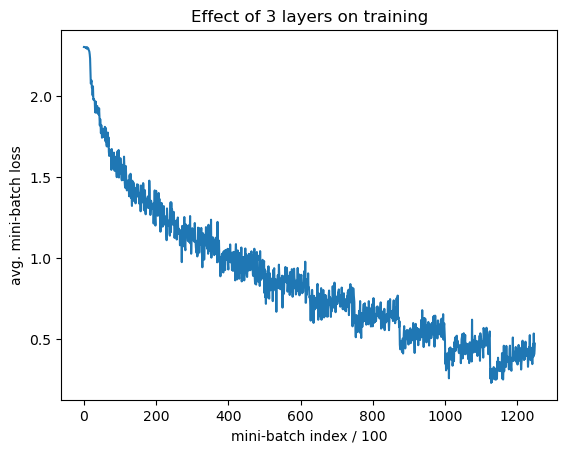

In [133]:
### three layer training curve
plt.plot(avg_losses_CustomCNN)
plt.xlabel('mini-batch index / {}'.format(print_freq))
plt.ylabel('avg. mini-batch loss')
plt.title("Effect of 3 layers on training")
plt.show()

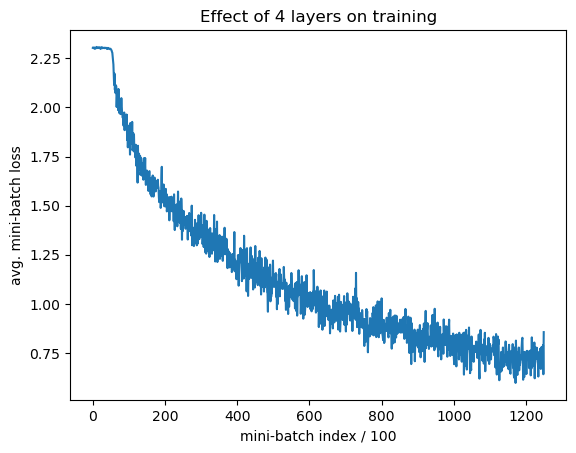

In [142]:
### four layers training curve
plt.plot(avg_losses_fourlayers)
plt.xlabel('mini-batch index / {}'.format(print_freq))
plt.ylabel('avg. mini-batch loss')
plt.title("Effect of 4 layers on training")
plt.show()

#### Test accuracy

In [291]:
#### 1.) 3 layer architecture
# Get test accuracy.
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = Layer_3(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 10 %


In [136]:
#### 2.) 4 layer architecture
# Get test accuracy.
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = Layer_4(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 71 %


## Conclusion for layers

The results are both interesting and concerning at the same time. While there was an increase in having 4 layers, (an increase from 67 to 71%), the addition of the 3rd layer appears to have led to a significant decrease and an anomaly, in that it only had a 10% test accuracy score.

With this in mind, while adding more layers can seem to improve it (albeit, only by 4%), there is significant room for debugging and improvement. In the latter stages of implementing all of the hyper-parameter tuning, an additional change can be to regularize and normalize it to help. The significant drop in the addition of the third layer may be attributed to the fact that there is no such normalization or regularization. This can be implemented via both dropout and normalizing in the data architecture.

As of this stage of testing, I did not nor plan to currently implement to fix that problem, as I want to look at the sole effect of layering. Of course, it is difficult to say adding more improved the performance significantly, but the 4 layered architecture appeared fine moving forward.

## Test 3: Different pooling function: max pooling

Now, we will test the effects of different pooling functions. Originally, we used average pooling. We will now test the effects of using max pooling

In [36]:
#### Max pooling
class MaxPool_Net(nn.Module):
    def __init__(self):
        super(MaxPool_Net, self).__init__()
        self.conv1 = nn.Sequential(
          nn.Conv2d(3, 20, 3, stride=1, padding=1),
          nn.ReLU(),
          nn.MaxPool2d(2)
        )
        self.conv2 = nn.Sequential(
          nn.Conv2d(20,20,3, stride=1, padding=1),
          nn.ReLU(),
          nn.MaxPool2d(2)
        )
        self.fc1= nn.Linear(1280 ,1280)
        self.fc2= nn.Linear(1280,100)
        self.fc3 = nn.Linear(100,10)

        self.relu= nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = torch.flatten(x, 1) 
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.fc3(x)
    
        return x

MaxPool_Layer = MaxPool_Net()
MaxPool_Layer.to(device)

MaxPool_Net(
  (conv1): Sequential(
    (0): Conv2d(3, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=1280, out_features=1280, bias=True)
  (fc2): Linear(in_features=1280, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=10, bias=True)
  (relu): ReLU()
)

#### Optimizer function

Loss and optimizer functions (currently) are kept constant.

In [37]:
###for max pooling architecture
opt_maxp = optim.SGD(MaxPool_Layer.parameters(), lr=0.001, momentum=0.9)

#### Training 

In [38]:
#### Max Pooling CNN training
avg_losses_maxpool = []   # Avg. losses.
epochs = 10       # Total epochs.
print_freq = 100  # Print frequency.

for epoch in range(epochs):  # Loop over the dataset multiple times.
    running_loss = 0.0       # Initialize running loss.
    for i, data in enumerate(trainloader, 0):
        # Get the inputs.
        inputs, labels = data
        
        # Move the inputs to the specified device.
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients.
        opt_maxp.zero_grad()

        # Forward step.
        outputs = MaxPool_Layer(inputs)
        loss = loss_func(outputs, labels)
        
        # Backward step.
        loss.backward()
        
        # Optimization step (update the parameters).
        opt_maxp.step()

        # Print statistics.
        running_loss += loss.item()
        if i % print_freq == print_freq - 1: # Print every several mini-batches.
            avg_loss = running_loss / print_freq
            print('[epoch: {}, i: {:5d}] avg mini-batch loss: {:.3f}'.format(
                epoch, i, avg_loss))
            avg_losses_maxpool.append(avg_loss)
            running_loss = 0.0

print('Finished Training.')

[epoch: 0, i:    99] avg mini-batch loss: 2.307
[epoch: 0, i:   199] avg mini-batch loss: 2.299
[epoch: 0, i:   299] avg mini-batch loss: 2.295
[epoch: 0, i:   399] avg mini-batch loss: 2.287
[epoch: 0, i:   499] avg mini-batch loss: 2.262
[epoch: 0, i:   599] avg mini-batch loss: 2.245
[epoch: 0, i:   699] avg mini-batch loss: 2.193
[epoch: 0, i:   799] avg mini-batch loss: 2.133
[epoch: 0, i:   899] avg mini-batch loss: 2.025
[epoch: 0, i:   999] avg mini-batch loss: 2.027
[epoch: 0, i:  1099] avg mini-batch loss: 2.033
[epoch: 0, i:  1199] avg mini-batch loss: 1.984
[epoch: 0, i:  1299] avg mini-batch loss: 1.965
[epoch: 0, i:  1399] avg mini-batch loss: 1.961
[epoch: 0, i:  1499] avg mini-batch loss: 1.880
[epoch: 0, i:  1599] avg mini-batch loss: 1.866
[epoch: 0, i:  1699] avg mini-batch loss: 1.900
[epoch: 0, i:  1799] avg mini-batch loss: 1.817
[epoch: 0, i:  1899] avg mini-batch loss: 1.872
[epoch: 0, i:  1999] avg mini-batch loss: 1.886
[epoch: 0, i:  2099] avg mini-batch loss

#### Training curve

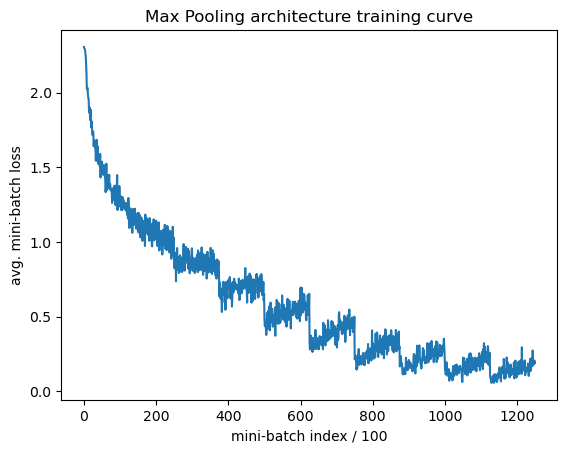

In [105]:
#### Max Pooling training curve
plt.plot(avg_losses_maxpool)
plt.xlabel('mini-batch index / {}'.format(print_freq))
plt.ylabel('avg. mini-batch loss')
plt.title("Max Pooling architecture training curve")
plt.show()

#### Test accuracy

In [106]:
#Max pooling test accuracy score
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = MaxPool_Layer(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 68 %


## Max Pooling conclusion

A huge concern with the max pooling is the resulting test accuracy being 68%. This is insightful but also assuring, as much of the literature online and discourse discusses how many of the modern CNNs utilize max pooling over other pooling functions.



## Test 4: Different activation functions

As ReLU has already been tested, the implementation of sigmoid and tanh activation functions will be looked at to see if there's a significant change in performance.

In [14]:
#### Sigmoid architecture
class Sigmoid_Net(nn.Module):
    def __init__(self):
        super(Sigmoid_Net, self).__init__()
        self.conv1 = nn.Sequential(
          nn.Conv2d(3, 20, 3, stride=1, padding=1),
          nn.Sigmoid(),
          nn.AvgPool2d(2)
        )
        self.conv2 = nn.Sequential(
          nn.Conv2d(20,20,3, stride=1, padding=1),
          nn.Sigmoid(),
          nn.AvgPool2d(2)
        )
        self.fc1= nn.Linear(20 * 8 * 8,1280)
        self.fc2= nn.Linear(1280,100)
        self.relu= nn.ReLU()
        self.fc3 = nn.Linear(100,10)
      
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = torch.flatten(x,1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.fc3(x)
    
        return x

SM_net = Sigmoid_Net()     # Create the network instance.
SM_net.to(device)  # Move the network parameters to the specified device.

Sigmoid_Net(
  (conv1): Sequential(
    (0): Conv2d(3, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Sigmoid()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (conv2): Sequential(
    (0): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Sigmoid()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (fc1): Linear(in_features=1280, out_features=1280, bias=True)
  (fc2): Linear(in_features=1280, out_features=100, bias=True)
  (relu): ReLU()
  (fc3): Linear(in_features=100, out_features=10, bias=True)
)

In [15]:
#### tanh architecture
class tanh_Net(nn.Module):
    def __init__(self):
        super(tanh_Net, self).__init__()
        self.conv1 = nn.Sequential(
          nn.Conv2d(3, 20, 3, stride=1, padding=1),
          nn.Tanh(),
          nn.AvgPool2d(2)
        )
        self.conv2 = nn.Sequential(
          nn.Conv2d(20,20,3, stride=1, padding=1),
          nn.Tanh(),
          nn.AvgPool2d(2)
        )
        self.fc1= nn.Linear(20 * 8 * 8,1280)
        self.fc2= nn.Linear(1280,100)
        self.relu= nn.ReLU()
        self.fc3 = nn.Linear(100,10)
      
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = torch.flatten(x,1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.fc3(x)
    
        return x

tanh_Net = tanh_Net()     # Create the network instance.
tanh_Net.to(device)  # Move the network parameters to the specified device.

tanh_Net(
  (conv1): Sequential(
    (0): Conv2d(3, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (conv2): Sequential(
    (0): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (fc1): Linear(in_features=1280, out_features=1280, bias=True)
  (fc2): Linear(in_features=1280, out_features=100, bias=True)
  (relu): ReLU()
  (fc3): Linear(in_features=100, out_features=10, bias=True)
)

### Optimizer

In [16]:
###for sigmoid
opt_sig = optim.Adam(SM_net.parameters(), lr=0.001)

###for tanh 
opt_tanh = optim.Adam(tanh_Net.parameters(), lr=0.001)

#### Training 


In [20]:
#### sigmoid
avg_losses_sig = []   # Avg. losses.
epochs = 10       # Total epochs.
print_freq = 100  # Print frequency.

for epoch in range(epochs):  # Loop over the dataset multiple times.
    running_loss = 0.0       # Initialize running loss.
    for i, data in enumerate(trainloader, 0):
        # Get the inputs.
        inputs, labels = data
        
        # Move the inputs to the specified device.
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients.
        opt_sig.zero_grad()

        # Forward step.
        outputs = SM_net(inputs)
        loss = loss_func(outputs, labels)
        
        # Backward step.
        loss.backward()
        
        # Optimization step (update the parameters).
        opt_sig.step()

        # Print statistics.
        running_loss += loss.item()
        if i % print_freq == print_freq - 1: # Print every several mini-batches.
            avg_loss = running_loss / print_freq
            print('[epoch: {}, i: {:5d}] avg mini-batch loss: {:.3f}'.format(
                epoch, i, avg_loss))
            avg_losses_sig.append(avg_loss)
            running_loss = 0.0

print('Finished Training.')

[epoch: 0, i:    99] avg mini-batch loss: 2.332
[epoch: 0, i:   199] avg mini-batch loss: 2.315
[epoch: 0, i:   299] avg mini-batch loss: 2.307
[epoch: 0, i:   399] avg mini-batch loss: 2.300
[epoch: 0, i:   499] avg mini-batch loss: 2.310
[epoch: 0, i:   599] avg mini-batch loss: 2.302
[epoch: 0, i:   699] avg mini-batch loss: 2.271
[epoch: 0, i:   799] avg mini-batch loss: 2.205
[epoch: 0, i:   899] avg mini-batch loss: 2.098
[epoch: 0, i:   999] avg mini-batch loss: 2.143
[epoch: 0, i:  1099] avg mini-batch loss: 2.091
[epoch: 0, i:  1199] avg mini-batch loss: 2.078
[epoch: 0, i:  1299] avg mini-batch loss: 2.093
[epoch: 0, i:  1399] avg mini-batch loss: 2.105
[epoch: 0, i:  1499] avg mini-batch loss: 2.003
[epoch: 0, i:  1599] avg mini-batch loss: 2.020
[epoch: 0, i:  1699] avg mini-batch loss: 2.012
[epoch: 0, i:  1799] avg mini-batch loss: 2.052
[epoch: 0, i:  1899] avg mini-batch loss: 1.998
[epoch: 0, i:  1999] avg mini-batch loss: 1.958
[epoch: 0, i:  2099] avg mini-batch loss

In [17]:
#### tanh
avg_losses_tanh = []   # Avg. losses.
epochs = 10       # Total epochs.
print_freq = 100  # Print frequency.

for epoch in range(epochs):  # Loop over the dataset multiple times.
    running_loss = 0.0       # Initialize running loss.
    for i, data in enumerate(trainloader, 0):
        # Get the inputs.
        inputs, labels = data
        
        # Move the inputs to the specified device.
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients.
        opt_tanh.zero_grad()

        # Forward step.
        outputs = tanh_Net(inputs)
        loss = loss_func(outputs, labels)
        
        # Backward step.
        loss.backward()
        
        # Optimization step (update the parameters).
        opt_tanh.step()

        # Print statistics.
        running_loss += loss.item()
        if i % print_freq == print_freq - 1: # Print every several mini-batches.
            avg_loss = running_loss / print_freq
            print('[epoch: {}, i: {:5d}] avg mini-batch loss: {:.3f}'.format(
                epoch, i, avg_loss))
            avg_losses_tanh.append(avg_loss)
            running_loss = 0.0

print('Finished Training.')

[epoch: 0, i:    99] avg mini-batch loss: 2.127
[epoch: 0, i:   199] avg mini-batch loss: 2.148
[epoch: 0, i:   299] avg mini-batch loss: 2.075
[epoch: 0, i:   399] avg mini-batch loss: 2.013
[epoch: 0, i:   499] avg mini-batch loss: 1.938
[epoch: 0, i:   599] avg mini-batch loss: 1.916
[epoch: 0, i:   699] avg mini-batch loss: 1.952
[epoch: 0, i:   799] avg mini-batch loss: 1.872
[epoch: 0, i:   899] avg mini-batch loss: 1.804
[epoch: 0, i:   999] avg mini-batch loss: 1.871
[epoch: 0, i:  1099] avg mini-batch loss: 1.866
[epoch: 0, i:  1199] avg mini-batch loss: 1.849
[epoch: 0, i:  1299] avg mini-batch loss: 1.767
[epoch: 0, i:  1399] avg mini-batch loss: 1.884
[epoch: 0, i:  1499] avg mini-batch loss: 1.766
[epoch: 0, i:  1599] avg mini-batch loss: 1.784
[epoch: 0, i:  1699] avg mini-batch loss: 1.737
[epoch: 0, i:  1799] avg mini-batch loss: 1.744
[epoch: 0, i:  1899] avg mini-batch loss: 1.768
[epoch: 0, i:  1999] avg mini-batch loss: 1.776
[epoch: 0, i:  2099] avg mini-batch loss

#### Training Curve

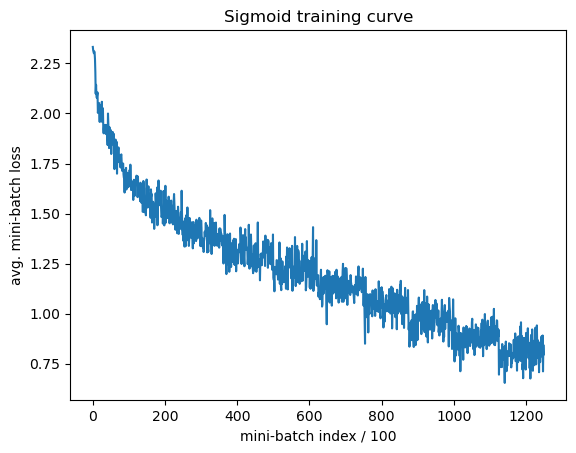

In [68]:
#### sigmoid
plt.plot(avg_losses_sig)
plt.xlabel('mini-batch index / {}'.format(print_freq))
plt.ylabel('avg. mini-batch loss')
plt.title("Sigmoid training curve")
plt.show()

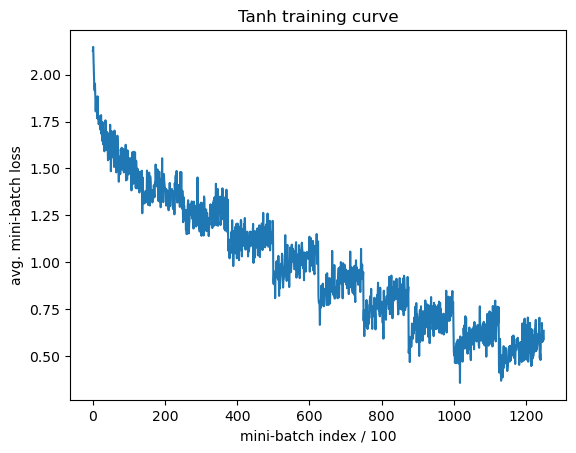

In [69]:
#### tanh
plt.plot(avg_losses_tanh)
plt.xlabel('mini-batch index / {}'.format(print_freq))
plt.ylabel('avg. mini-batch loss')
plt.title("Tanh training curve")
plt.show()

#### Test accuracy

In [28]:
###sigmoid
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device_CustomCNN), labels.to(device_CustomCNN)
        outputs = SM_net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 59 %


In [29]:
###tanh
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = tanh_Net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 54 %


## Conclusion on activation functions

Before discussing the results, its important to note how Adam had to be implemented in the optimizer, despite wanting to remain consisent in all other variables to see the true effect. This is because the training would show up as not changing in the mini-batch losses, and this is due to the vanishing gradient problem with sigmoid and tanh. Adam was used to try to combat this.

Moving on, the results showed 59% and 54% respectively for both sigmoid and tanh activation functions. While a good percentage, in comparison to ReLU at 67%, they underperformed but serve as decent activation functions for the CNN.

## Using the hyper-parameter testing to create my project's 'ideal' CNN architecture

In [100]:
#### Based on previous testing, I combine the best portions (more layers, different pooling and activation functions)
#### to see if I get the performance increase from the original 67%

class Final_CNN(nn.Module):
    def __init__(self):
        super(Final_CNN, self).__init__()
        self.conv1 = nn.Sequential(
          nn.Conv2d(3, 20, 3, stride=1, padding=1),
          nn.ReLU()
        )
        self.conv2 = nn.Sequential(
          nn.Conv2d(20,20,3, stride=1, padding=1),
          nn.ReLU()
        )
        self.conv3 = nn.Sequential(
          nn.Conv2d(20,20,3, stride=1, padding=1),
          nn.ReLU(),
          nn.MaxPool2d(2)
        )
        self.conv4 = nn.Sequential(
          nn.Conv2d(20,20,3, stride=1, padding=1),
          nn.ReLU(),
          nn.MaxPool2d(2)
        )
        self.fc1= nn.Linear(1280,1280)
        self.fc2= nn.Linear(1280,100)
        self.relu= nn.ReLU()
        self.fc3 = nn.Linear(100,10)
      
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = torch.flatten(x,1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.fc3(x)
    
        return x

FCNN_net = Final_CNN()     # Create the network instance.
FCNN_net.to(device)  # Move the network parameters to the specified device.


Final_CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (conv3): Sequential(
    (0): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=1280, out_features=1280, bias=True)
  (fc2): Linear(in_features=1280, out_features=100, bias=True)
  (relu): ReLU()
  (fc3): Linear(in_features=100, out_features=10, bias=True)
)

#### Optimizer 


In [101]:
### for the final CNN
opt_FCNN = optim.SGD(FCNN_net.parameters(), lr=0.001, momentum=0.9)

### Training


In [102]:
#### Final CNN training
avg_losses_final = []   # Avg. losses.
epochs = 10       # Total epochs.
print_freq = 100  # Print frequency.

for epoch in range(epochs):  # Loop over the dataset multiple times.
    running_loss = 0.0       # Initialize running loss.
    for i, data in enumerate(trainloader, 0):
        # Get the inputs.
        inputs, labels = data
        
        # Move the inputs to the specified device.
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients.
        opt_FCNN.zero_grad()

        # Forward step.
        outputs = FCNN_net(inputs)
        loss = loss_func(outputs, labels)
        
        # Backward step.
        loss.backward()
        
        # Optimization step (update the parameters).
        opt_FCNN.step()

        # Print statistics.
        running_loss += loss.item()
        if i % print_freq == print_freq - 1: # Print every several mini-batches.
            avg_loss = running_loss / print_freq
            print('[epoch: {}, i: {:5d}] avg mini-batch loss: {:.3f}'.format(
                epoch, i, avg_loss))
            avg_losses_final.append(avg_loss)
            running_loss = 0.0

print('Finished Training.')

[epoch: 0, i:    99] avg mini-batch loss: 2.299
[epoch: 0, i:   199] avg mini-batch loss: 2.303
[epoch: 0, i:   299] avg mini-batch loss: 2.308
[epoch: 0, i:   399] avg mini-batch loss: 2.308
[epoch: 0, i:   499] avg mini-batch loss: 2.303
[epoch: 0, i:   599] avg mini-batch loss: 2.305
[epoch: 0, i:   699] avg mini-batch loss: 2.301
[epoch: 0, i:   799] avg mini-batch loss: 2.303
[epoch: 0, i:   899] avg mini-batch loss: 2.300
[epoch: 0, i:   999] avg mini-batch loss: 2.298
[epoch: 0, i:  1099] avg mini-batch loss: 2.291
[epoch: 0, i:  1199] avg mini-batch loss: 2.280
[epoch: 0, i:  1299] avg mini-batch loss: 2.250
[epoch: 0, i:  1399] avg mini-batch loss: 2.208
[epoch: 0, i:  1499] avg mini-batch loss: 2.212
[epoch: 0, i:  1599] avg mini-batch loss: 2.165
[epoch: 0, i:  1699] avg mini-batch loss: 2.162
[epoch: 0, i:  1799] avg mini-batch loss: 2.119
[epoch: 0, i:  1899] avg mini-batch loss: 2.136
[epoch: 0, i:  1999] avg mini-batch loss: 2.115
[epoch: 0, i:  2099] avg mini-batch loss

### Training curve


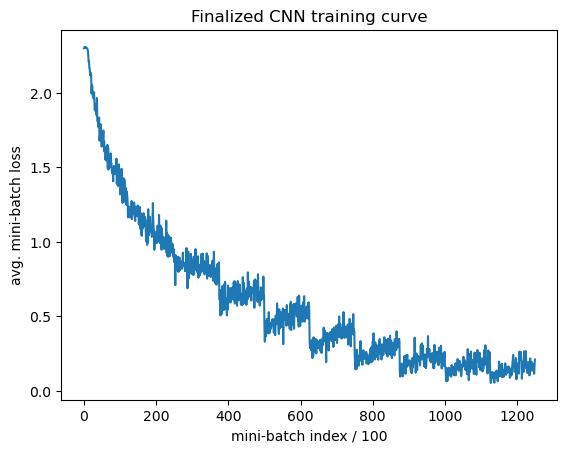

In [107]:
#### Final CNN training curve
plt.plot(avg_losses_final)
plt.xlabel('mini-batch index / {}'.format(print_freq))
plt.ylabel('avg. mini-batch loss')
plt.title("Finalized CNN training curve")
plt.show()

### Test accuracy

In [108]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = FCNN_net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 70 %
